In [32]:
#this code is inspired by https://github.com/kimiandj/gsw/blob/master/code/GSW_flows_comparison.ipynb
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import optim
import ot
import pandas as pd
from tqdm import tqdm
from IPython import display
import time
import matplotlib.pyplot as pl
import scienceplots

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import os
import gradient_flows

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/lchapel/Documents/2024/Partial 1d - a new hope/partial_ot_1d/gradient_flows.py:43: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  temp=np.random.multivariate_normal(mu_s, cov_s, int(N*0.8))


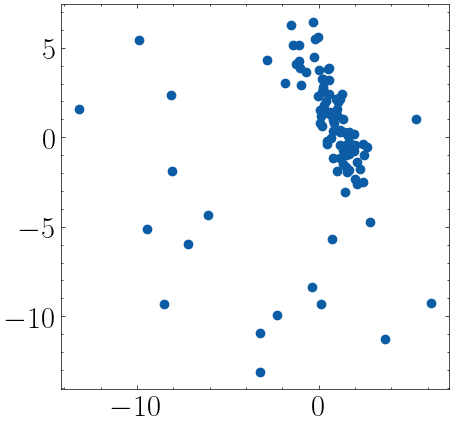

In [42]:
%load_ext autoreload
%autoreload 2
dataset_name = 'gaussian_2d_with_noise'
seed=0

np.random.seed(seed)
N = 100  # Number of samples from p_X
X = gradient_flows.load_data(name=dataset_name, n_samples=N,dim=2) #20% of noise
X -= X.mean(dim=0)[np.newaxis,:]  
#X-=torch.tensor([5,5])
meanX = 0

# plot the dataset
_, d = X.shape
fig = pl.figure(figsize=(5,5))
pl.scatter(X[:,0], X[:,1])
pl.show()

In [43]:
results_folder = './Results/Gradient_Flow'
if not os.path.isdir(results_folder):
    os.mkdir(results_folder)
foldername = os.path.join(results_folder, 'Gifs')
if not os.path.isdir(foldername):
    os.mkdir(foldername)
    
foldername = os.path.join(results_folder, 'Gifs', dataset_name + '_Comparison')
if not os.path.isdir(foldername):
    os.mkdir(foldername)

In [44]:
# Use GPU if available, CPU otherwise
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device='cpu'
print(device)

cpu


In [49]:
np.random.seed(seed)

# Number of iterations for the optimization process
nofiterations = 400

modes = ['linear', 'linear', 'linear','linear','linear']
titles = ['SW (Vanilla OT)', 'SWGG (Vanilla OT)', 'SW (Partial OT)', 'SWGG (Partial OT)', 'SWGG (Partial OT - elbow)']

lear_rates=5*[5e-2]

#nb_iteration = [1,200,1,200]
n_proj = [100,100,100,100, 100]


# Define the initial distribution
temp = np.random.normal(loc=np.array([5, 5]), scale=.25, size=(N,d))

dist = 'w2'
w2_dist = np.nan * np.zeros((nofiterations, len(modes)))
w2_dist_partial = np.nan * np.zeros((nofiterations, len(modes)))


# Define the optimizers
Y = list()
optimizer = list()
gsw_res = list()

for k in range(len(modes)):
    if k > 1: #for partial scheme: only the good amount of samples into the target distribution
        temp = np.random.normal(loc=np.array([5, 5]), scale=.25, size=(int(N),d))
    Y.append(torch.tensor(temp, dtype=torch.float, device=device, requires_grad=True))
    optimizer.append(optim.Adam([Y[k]], lr = lear_rates[k]))
    gsw_res.append(gradient_flows.GF(ftype=modes[k], nofprojections=n_proj[k],device=device))

KeyboardInterrupt: 

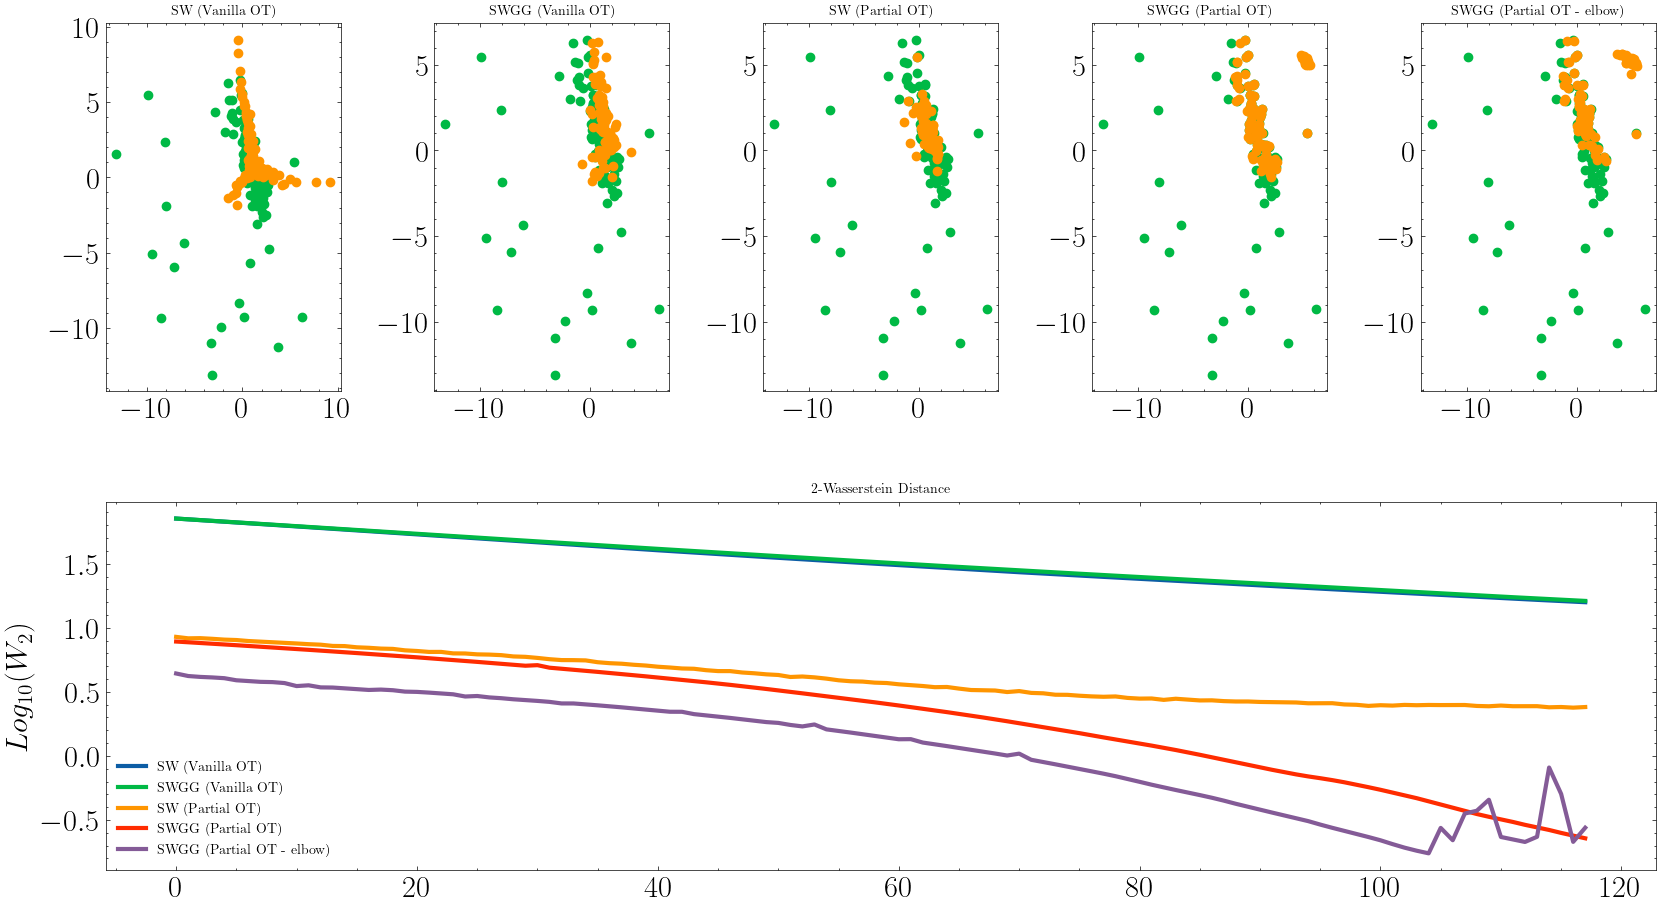

In [50]:
s = len(modes)

fig.clear()
fig = pl.figure(figsize=(4*s, 8+3))
grid = pl.GridSpec(2, s, wspace=.4, hspace=0.3)

e_swggp = 0

plot_fig = True
mem_loss = []

#nofiterations = 5
for i in range(nofiterations):
    print(i,end=' ')
    loss = list()
    theta = torch.ones(len(modes),d)
    
    for k in range(s):
        # Loss computation
        #loss_ = 0
        if k == 0:
            print(X.shape, Y[0].shape)
            l = gsw_res[k].sw(X.to(device), Y[k],theta=None)
        if k == 1:
            l, theta[k] = gsw_res[k].swgg(X.to(device), Y[k].to(device),theta=None)
        if k == 2:
            l, X_swp, Y_swp = gsw_res[k].sw_partial(X.to(device), Y[k],theta=None, k = N*0.8)
        if k==3:
            l, theta[k], X_swggp, Y_swggp = gsw_res[k].swgg_partial(X.to(device), Y[k], theta=None, k = N*0.8)
        if k==4:
            l, theta[k], X_swggp_e, Y_swggp_e, e_swggp = gsw_res[k].swgg_partial_elbow(X.to(device), Y[k], theta=None, s = 1)
        
        print(e_swggp)
        # Optimization step
        loss_ = l
        loss.append(loss_)
        optimizer[k].zero_grad()
        loss[k].backward()
        optimizer[k].step()
        
        # Compute the 2-Wasserstein distance to compare the distributions
        if dist=='w2':
            w2_dist[i, k] = gradient_flows.w2(X.detach().cpu().numpy(), Y[k].detach().cpu().numpy())
            w2_dist_partial[i, k] = l#gradient_flows.w2(X.detach().cpu().numpy()[:n_samples_mode2*2], Y[k][ :n_samples_mode2*2].detach().cpu().numpy())
 
             
        theta2=theta.numpy()

        if plot_fig:
                temp = Y[k].detach().cpu().numpy()
                pl.subplot(grid[0, k])
                pl.cla()
                pl.scatter(X[:,0], X[:,1], c='C1')
                #pl.scatter(X[n_samples_mode1: n_samples_mode2+n_samples_mode1,0], X[n_samples_mode1:n_samples_mode2+n_samples_mode1,1], c='C0')
                pl.scatter(temp[:,0], temp[:,1],c='C2')
                #pl.scatter(temp[n_samples_mode2: n_samples_mode2+n_samples_mode1,0], temp[n_samples_mode2: n_samples_mode2+n_samples_mode1,1],c='C3')
                #pl.axline((0,0), theta2[k][0:2], color='C2')
                pl.title(titles[k], fontsize=10)
                xlim1,xlim2=pl.xlim()
                ylim1,ylim2=pl.ylim()
                pl.title(titles[k], fontsize=10)
    if plot_fig:
    # Plot the (partial) 2-Wasserstein distance
        pl.subplot(grid[1, 0:s])
        pl.cla()
        pl.plot(np.log10(w2_dist[:,:2]), linewidth=3)
        pl.plot(np.log10(w2_dist_partial[:,2:]), linewidth=3)
        pl.title('2-Wasserstein Distance', fontsize=10)
        pl.ylabel(r'$Log_{10}(W_2)$', fontsize=22)
        pl.legend(titles, fontsize=10, loc='lower left')
        
        
        display.clear_output(wait=True)
        display.display(pl.gcf()) 
        time.sleep(1e-5)    

        
    # Save the figure 
    
    fig.savefig(foldername + '/img%03d.png'%(i))
    for k in range(s):
        #pl.subplot(grid[:, k])
        pl.cla()
        
            
            

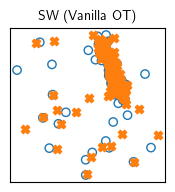

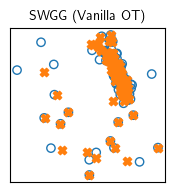

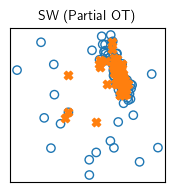

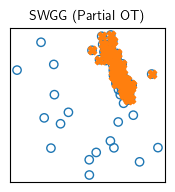

In [94]:
for k in range(4):
    pl.figure(1, figsize=(2, 2))
    temp = Y[k].detach().cpu().numpy()
    pl.scatter(X[:,0], X[:,1], facecolors='none', edgecolors='C0')
    pl.scatter(temp[:,0], temp[:,1], marker = 'X', facecolors='none', c='C1')
    pl.title(titles[k], fontsize=10)
    pl.xticks([]) 
    pl.yticks([]) 
    pl.savefig(foldername + '/final%03d.pdf'%(k))
    pl.show()

# Bimodal clusters experiment

In [14]:
from sklearn import cluster, datasets
dataset_name = 'unbalanced bimodal distributions'

d = 2
n_samples_mode1 = 200 # the biggest one
n_samples_mode2 = 70


In [16]:

noisy_circles = datasets.make_circles(
    n_samples=n_samples_mode2*2, factor=0.8, noise=0.05, random_state=170
)

noisy_circles = noisy_circles[0][np.where(noisy_circles[1]==1)[0]]
noisy_circles[:,0] = noisy_circles[:,0] -6
noisy_circles[:,1] = noisy_circles[:,1] +2
noisy_moons = datasets.make_moons(n_samples=n_samples_mode2*2, noise=0.05, random_state=170)
noisy_moons = noisy_moons[0][np.where(noisy_moons[1]==1)[0]]
noisy_moons[:,1] = noisy_moons[:,1] -1
noisy_moons[:,0] = (noisy_moons[:,0]) * 1.5 
blobs = datasets.make_blobs(n_samples=n_samples_mode1, centers=1, random_state=170)
blobs = (blobs[0]+3)/3
blobs[:,0] =  (blobs[:,0]*2) -4
rng = np.random.RandomState(170)
no_structure = rng.rand(n_samples_mode1, 2)-2
no_structure[:,1] = no_structure[:,1]*1.5 +5
no_structure[:,0] = no_structure[:,0] + 4

source = np.concatenate((noisy_circles, no_structure))
source = torch.from_numpy(source).float()

X = np.concatenate((blobs, noisy_moons))
X = torch.from_numpy(X).float()
_, d = X.shape


In [17]:
results_folder = './Results/Gradient_Flow'
if not os.path.isdir(results_folder):
    os.mkdir(results_folder)
foldername = os.path.join(results_folder, 'Gifs')
if not os.path.isdir(foldername):
    os.mkdir(foldername)
    
foldername = os.path.join(results_folder, 'Gifs', dataset_name + '_Comparison')
if not os.path.isdir(foldername):
    os.mkdir(foldername)

In [18]:
np.random.seed(seed)

# Number of iterations for the optimization process
nofiterations = 500

modes = ['linear', 'linear', 'linear','linear','linear']
titles = ['SW (Vanilla OT)', 'SWGG (Vanilla OT)', 'SW (Partial OT)', 'SWGG (Partial OT)', 'SWGG (Partial OT - elbow)']

lear_rates=5*[5e-2]

#nb_iteration = [1,200,1,200]
n_proj = [100,100,100,100, 100]


# Define the initial distribution
temp = np.random.normal(loc=np.array([5, 5]), scale=.25, size=(N,d))

dist = 'w2'
w2_dist = np.nan * np.zeros((nofiterations, len(modes)))
w2_dist_partial = np.nan * np.zeros((nofiterations, len(modes)))


# Define the optimizers
Y = list()
optimizer = list()
gsw_res = list()

for k in range(len(modes)):
    #if k > 1: #for partial scheme: only the good amount of samples into the target distribution
    #    temp = np.random.normal(loc=np.array([5, 5]), scale=.25, size=(int(N*.8),d))
    Y.append(torch.tensor(source, dtype=torch.float, device=device, requires_grad=True))
    optimizer.append(optim.Adam([Y[k]], lr = lear_rates[k]))
    gsw_res.append(gradient_flows.GF(ftype=modes[k], nofprojections=n_proj[k],device=device))


/var/folders/93/kzdc_fld6lzf2wdsrdy7ys980000gp/T/ipykernel_40305/4160727352.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y.append(torch.tensor(source, dtype=torch.float, device=device, requires_grad=True))
/var/folders/93/kzdc_fld6lzf2wdsrdy7ys980000gp/T/ipykernel_40305/4160727352.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y.append(torch.tensor(source, dtype=torch.float, device=device, requires_grad=True))


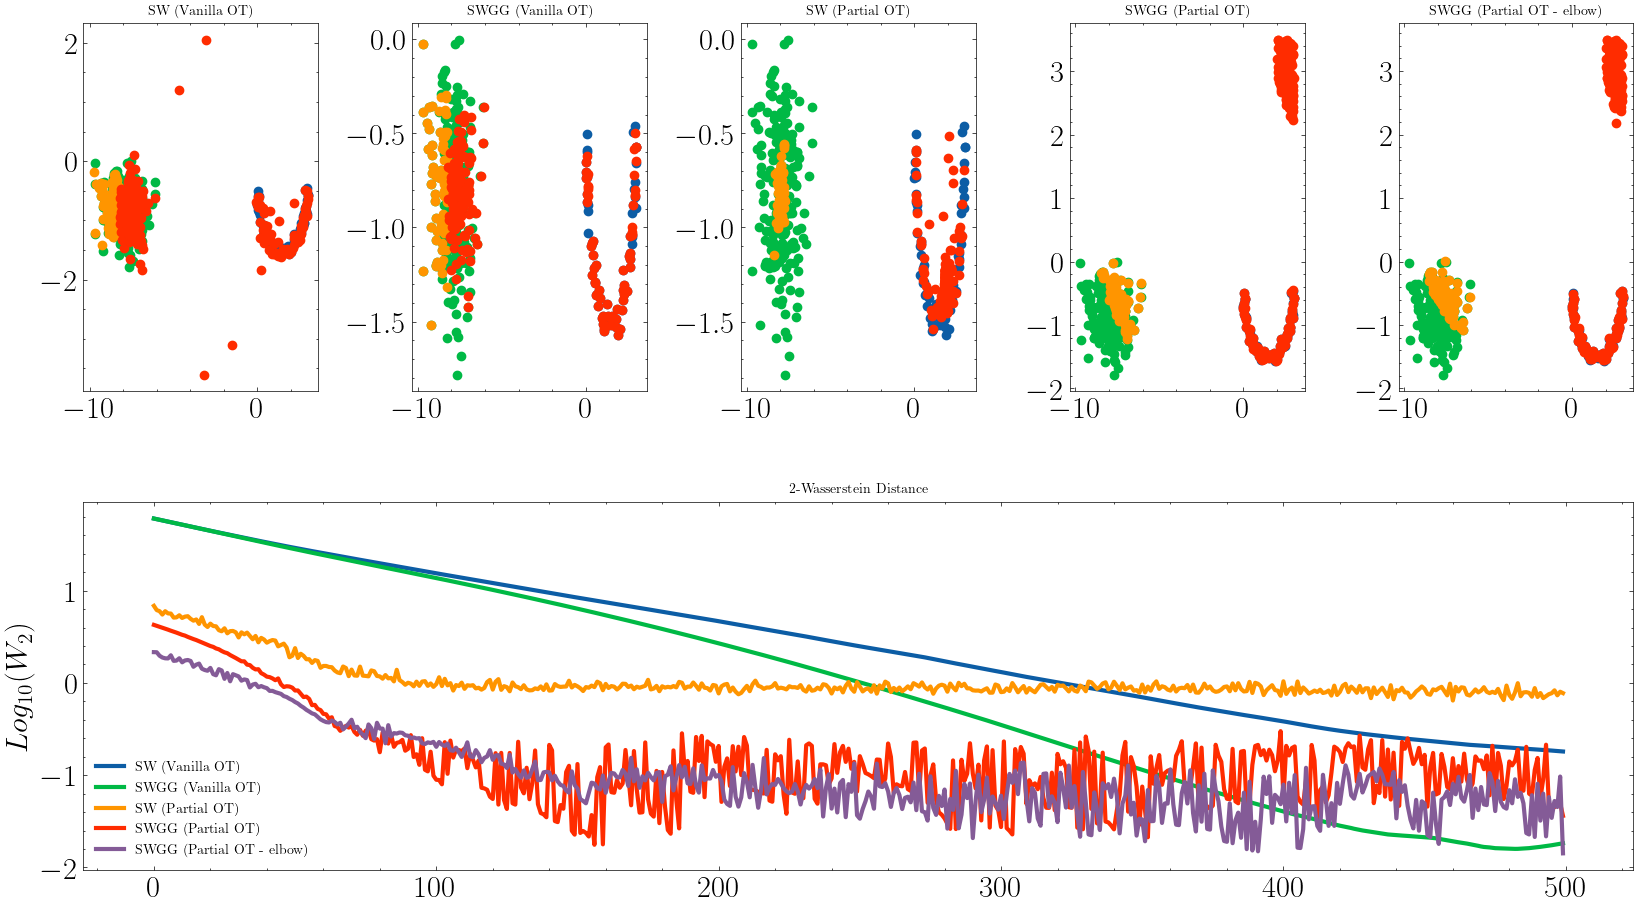

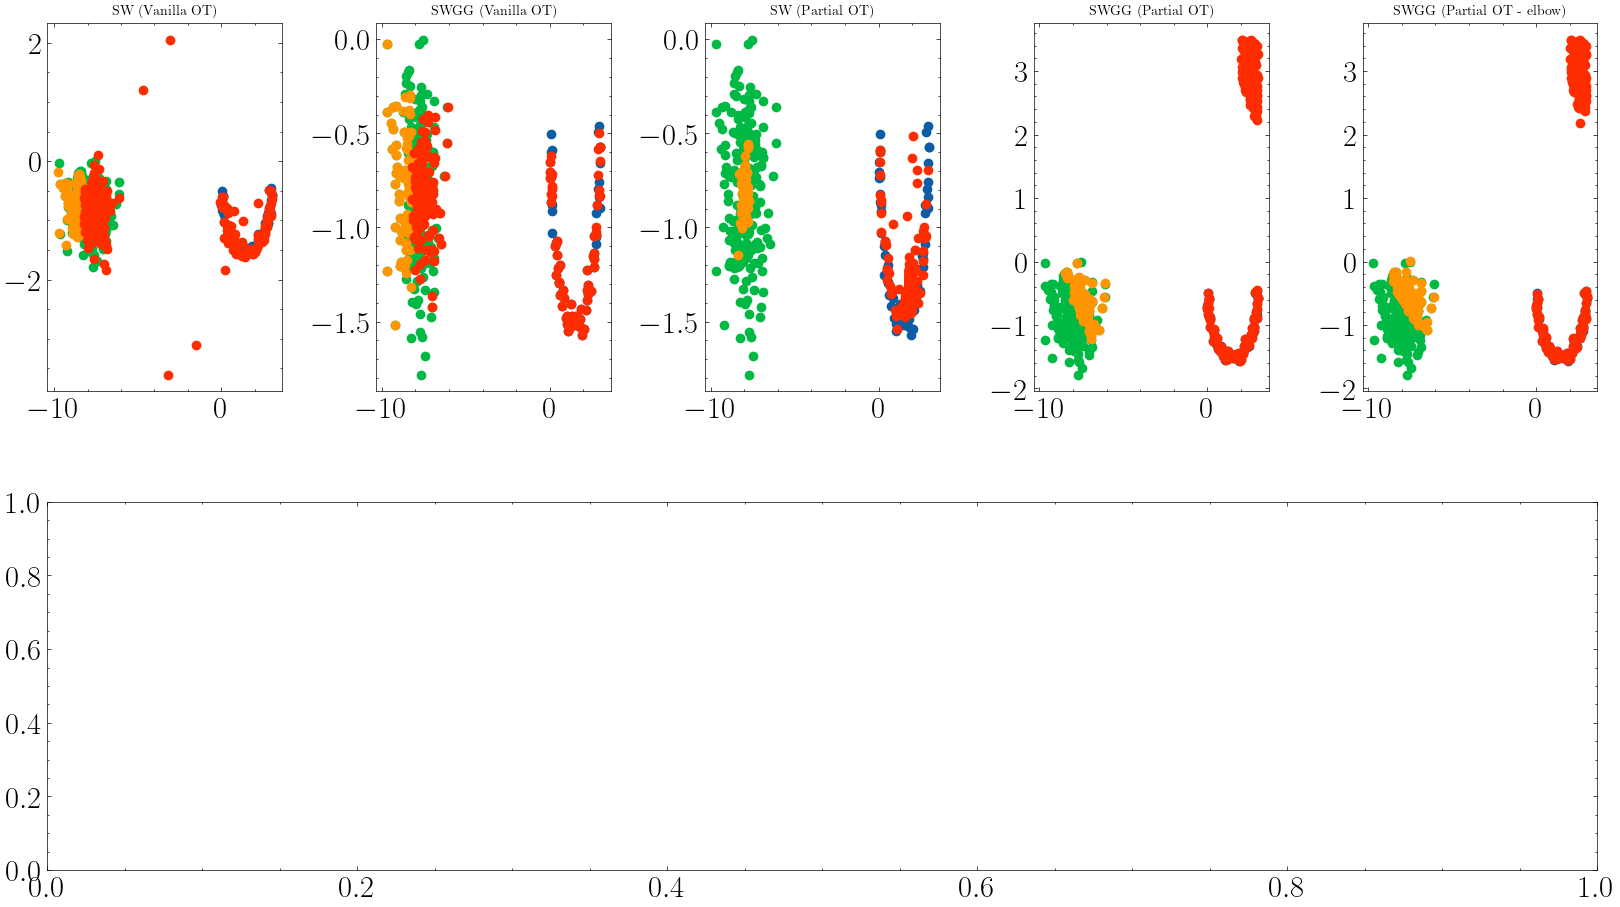

In [19]:
s = len(modes)

fig.clear()
fig = pl.figure(figsize=(4*s, 8+3))
grid = pl.GridSpec(2, s, wspace=.4, hspace=0.3)

e_swggp = 0

plot_fig = True
mem_loss = []

#nofiterations = 5
for i in range(nofiterations):
    print(i,end=' ')
    loss = list()
    theta = torch.ones(len(modes),d)
    
    for k in range(s):
        # Loss computation
        #loss_ = 0
        if k == 0:
            print(X.shape, Y[0].shape)
            l = gsw_res[k].sw(X.to(device), Y[k],theta=None)
        if k == 1:
            l, theta[k] = gsw_res[k].swgg(X.to(device), Y[k].to(device),theta=None)
        if k == 2:
            l, X_swp, Y_swp = gsw_res[k].sw_partial(X.to(device), Y[k],theta=None, k = n_samples_mode2*2)
        if k==3:
            l, theta[k], X_swggp, Y_swggp = gsw_res[k].swgg_partial(X.to(device), Y[k], theta=None, k = n_samples_mode2*2)
        if k==4:
            l, theta[k], X_swggp_e, Y_swggp_e, e_swggp = gsw_res[k].swgg_partial_elbow(X.to(device), Y[k], theta=None)
        
        print(e_swggp)
        # Optimization step
        loss_ = l
        loss.append(loss_)
        optimizer[k].zero_grad()
        loss[k].backward()
        optimizer[k].step()
        
        # Compute the 2-Wasserstein distance to compare the distributions
        if dist=='w2':
            w2_dist[i, k] = gradient_flows.w2(X.detach().cpu().numpy(), Y[k].detach().cpu().numpy())
            w2_dist_partial[i, k] = l#gradient_flows.w2(X.detach().cpu().numpy()[:n_samples_mode2*2], Y[k][ :n_samples_mode2*2].detach().cpu().numpy())
 
             
        theta2=theta.numpy()

        if plot_fig:
                temp = Y[k].detach().cpu().numpy()
                pl.subplot(grid[0, k])
                pl.cla()
                pl.scatter(X[:n_samples_mode1,0], X[:n_samples_mode1,1], c='C1')
                pl.scatter(X[n_samples_mode1: n_samples_mode2+n_samples_mode1,0], X[n_samples_mode1:n_samples_mode2+n_samples_mode1,1], c='C0')
                pl.scatter(temp[:n_samples_mode2,0], temp[:n_samples_mode2,1],c='C2')
                pl.scatter(temp[n_samples_mode2: n_samples_mode2+n_samples_mode1,0], temp[n_samples_mode2: n_samples_mode2+n_samples_mode1,1],c='C3')
                #pl.axline((0,0), theta2[k][0:2], color='C2')
                pl.title(titles[k], fontsize=10)
                xlim1,xlim2=pl.xlim()
                ylim1,ylim2=pl.ylim()
                pl.title(titles[k], fontsize=10)
    if plot_fig:
    # Plot the (partial) 2-Wasserstein distance
        pl.subplot(grid[1, 0:s])
        pl.cla()
        pl.plot(np.log10(w2_dist[:,:2]), linewidth=3)
        pl.plot(np.log10(w2_dist_partial[:,2:]), linewidth=3)
        pl.title('2-Wasserstein Distance', fontsize=10)
        pl.ylabel(r'$Log_{10}(W_2)$', fontsize=22)
        pl.legend(titles, fontsize=10, loc='lower left')
        
        
        display.clear_output(wait=True)
        display.display(pl.gcf()) 
        time.sleep(1e-5)    

        
    # Save the figure 
    
    fig.savefig(foldername + '/img%03d.png'%(i))
    for k in range(s):
        #pl.subplot(grid[:, k])
        pl.cla()
        
            
            

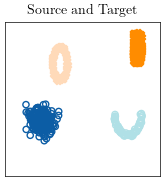

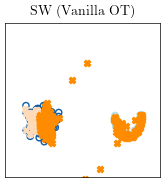

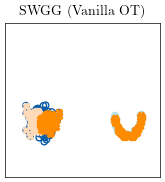

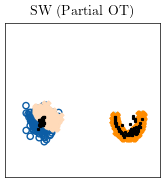

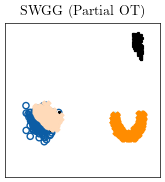

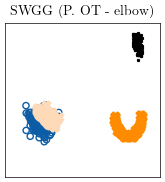

In [31]:
pl.rcParams['text.usetex'] = True
pl.style.use(['science'])
pl.rcParams.update({'font.size': 22})

titles = ['SW (Vanilla OT)', 'SWGG (Vanilla OT)', 'SW (Partial OT)', 'SWGG (Partial OT)', 'SWGG (P. OT - elbow)']

pl.figure(1, figsize=(2, 2))
temp = Y[k].detach().cpu().numpy()
if k == 1:
    Y_transp = Y_swp.detach().cpu().numpy()
elif k == 2:
    Y_transp = Y_swggp.detach().cpu().numpy()
elif k == 3:
    Y_transp = Y_swggp_e.detach().cpu().numpy()

#pl.scatter(X[:n_samples_mode1,0], X[:n_samples_mode1,1], c='C1')
#                pl.scatter(X[n_samples_mode1: n_samples_mode2+n_samples_mode1,0], X[n_samples_mode1:n_samples_mode2+n_samples_mode1,1], c='C0')
pl.scatter(source[:n_samples_mode2,0], source[:n_samples_mode2,1],  c='peachpuff', s=20, marker = 'X')
pl.scatter(source[n_samples_mode2: n_samples_mode2+n_samples_mode1,0], source[n_samples_mode2:n_samples_mode2+n_samples_mode1,1],  c='darkorange', s=20, marker = 'X')
pl.scatter(X[:n_samples_mode1,0], X[:n_samples_mode1,1], facecolors='none', edgecolors='C0', s=20)
pl.scatter(X[n_samples_mode1: n_samples_mode2+n_samples_mode1,0], X[n_samples_mode1:n_samples_mode2+n_samples_mode1,1], facecolors='none', edgecolors='powderblue', s=20)

#pl.scatter(source[:,0], source[:,1], marker = 'X', facecolors='none', c='tab:orange')
pl.title("Source and Target", fontsize=10)
pl.xticks([]) 
pl.yticks([]) 
pl.xlim([-12,5])
pl.ylim([-3.5,4])
pl.savefig(foldername + '/bimodalOriginal.pdf')
pl.show()

for k in range((len(modes))):
    pl.figure(1, figsize=(2, 2))
    temp = Y[k].detach().cpu().numpy()

    if k == 1:
        Y_transp = Y_swp.detach().cpu().numpy()
    elif k == 2:
        Y_transp = Y_swggp_e.detach().cpu().numpy()
    elif k == 3:
        Y_transp = Y_swggp_e.detach().cpu().numpy()


    pl.scatter(X[:n_samples_mode1,0], X[:n_samples_mode1,1], facecolors='none', edgecolors='C0', s=20)
    pl.scatter(X[n_samples_mode1: n_samples_mode2+n_samples_mode1,0], X[n_samples_mode1:n_samples_mode2+n_samples_mode1,1], facecolors='none', edgecolors='powderblue', s=20)
    if k == 2:
        pl.scatter(Y_transp[:n_samples_mode2,0], Y_transp[:n_samples_mode2,1],  c='peachpuff', s=40, marker = 'X')
        pl.scatter(Y_transp[n_samples_mode2: n_samples_mode2+n_samples_mode1,0], Y_transp[n_samples_mode2:n_samples_mode2+n_samples_mode1,1], color='darkorange', s=40, marker = 'X')
        pl.scatter(temp[:n_samples_mode2,0], temp[:n_samples_mode2,1],  c='black', s=2, marker = 'X')
        pl.scatter(temp[n_samples_mode2: n_samples_mode2+n_samples_mode1,0], temp[n_samples_mode2:n_samples_mode2+n_samples_mode1,1], color='black', s=2, marker = 'X')
    elif k >2:
        pl.scatter(temp[:n_samples_mode2,0], temp[:n_samples_mode2,1],  c='black', s=2, marker = 'X')
        pl.scatter(temp[n_samples_mode2: n_samples_mode2+n_samples_mode1,0], temp[n_samples_mode2:n_samples_mode2+n_samples_mode1,1], color='black', s=2, marker = 'X')
        pl.scatter(Y_transp[:n_samples_mode2,0], Y_transp[:n_samples_mode2,1],  c='peachpuff', s=40, marker = 'X')
        pl.scatter(Y_transp[n_samples_mode2: n_samples_mode2+n_samples_mode1,0], Y_transp[n_samples_mode2:n_samples_mode2+n_samples_mode1,1], color='darkorange', s=40, marker = 'X')
    else:
        pl.scatter(temp[:n_samples_mode2,0], temp[:n_samples_mode2,1],  c='peachpuff', s=20, marker = 'X')
        pl.scatter(temp[n_samples_mode2: n_samples_mode2+n_samples_mode1,0], temp[n_samples_mode2:n_samples_mode2+n_samples_mode1,1],  c='darkorange', s=20, marker = 'X')
    

    pl.title(titles[k], fontsize=10)
    pl.xticks([]) 
    pl.yticks([]) 
    pl.xlim([-12,5])
    pl.ylim([-3.5,4])
    pl.savefig(foldername + '/bimodal%03d.pdf'%(k))
    pl.show()

# test with the elbow

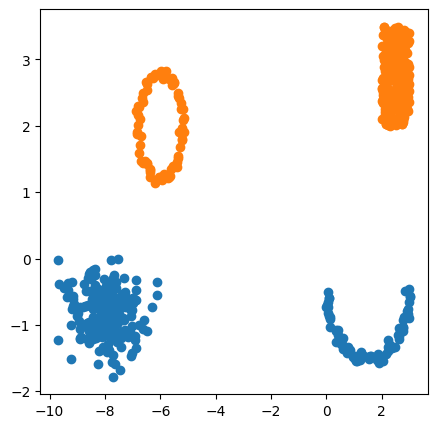

In [6]:
from sklearn import cluster, datasets
dataset_name = 'unbalanced bimodal distributions with elbow'

d = 2
n_samples_mode1 = 200 # the biggest one
n_samples_mode2 = 70


noisy_circles = datasets.make_circles(
    n_samples=n_samples_mode2*2, factor=0.8, noise=0.05, random_state=170
)

noisy_circles = noisy_circles[0][np.where(noisy_circles[1]==1)[0]]
noisy_circles[:,0] = noisy_circles[:,0] -6
noisy_circles[:,1] = noisy_circles[:,1] +2
noisy_moons = datasets.make_moons(n_samples=n_samples_mode2*2, noise=0.05, random_state=170)
noisy_moons = noisy_moons[0][np.where(noisy_moons[1]==1)[0]]
noisy_moons[:,1] = noisy_moons[:,1] -1
noisy_moons[:,0] = (noisy_moons[:,0]) * 1.5 
blobs = datasets.make_blobs(n_samples=n_samples_mode1, centers=1, random_state=170)
blobs = (blobs[0]+3)/3
blobs[:,0] =  (blobs[:,0]*2) -4
rng = np.random.RandomState(170)
no_structure = rng.rand(n_samples_mode1, 2)-2
no_structure[:,1] = no_structure[:,1]*1.5 +5
no_structure[:,0] = no_structure[:,0] + 4

source = np.concatenate((noisy_circles, no_structure))
source = torch.from_numpy(source).float()

X = np.concatenate((blobs, noisy_moons))
X = torch.from_numpy(X).float()
#X -= X.mean(dim=0)[np.newaxis,:]  
#meanX = 0
_, d = X.shape

# plot the target dataset
_, d = X.shape
fig = pl.figure(figsize=(5,5))
pl.scatter(X[:,0], X[:,1])
pl.scatter(source[:,0], source[:,1])
pl.show()


results_folder = './Results/Gradient_Flow'
if not os.path.isdir(results_folder):
    os.mkdir(results_folder)
foldername = os.path.join(results_folder, 'Gifs')
if not os.path.isdir(foldername):
    os.mkdir(foldername)
    
foldername = os.path.join(results_folder, 'Gifs', dataset_name + '_Comparison')
if not os.path.isdir(foldername):
    os.mkdir(foldername)

In [7]:
np.random.seed(seed)

# Number of iterations for the optimization process
nofiterations = 500

modes = ['linear', 'linear', 'linear','linear']
titles = ['SW (Vanilla OT)', 'SWGG (Vanilla OT)', 'SW (Partial OT)', 'SWGG (Partial OT)']

lear_rates=4*[5e-2]

#nb_iteration = [1,200,1,200]
n_proj = [100,100,100,100]


# Define the initial distribution
temp = np.random.normal(loc=np.array([5, 5]), scale=.25, size=(N,d))

dist = 'w2'
w2_dist = np.nan * np.zeros((nofiterations, len(modes)))
w2_dist_partial = np.nan * np.zeros((nofiterations, len(modes)))


# Define the optimizers
Y = list()
optimizer = list()
gsw_res = list()
X_swp = list()
Y_swp = list()
X_swggp = list()
Y_swggp = list()

for k in range(len(modes)):
    #if k > 1: #for partial scheme: only the good amount of samples into the target distribution
    #    temp = np.random.normal(loc=np.array([5, 5]), scale=.25, size=(int(N*.8),d))
    Y.append(torch.tensor(source, dtype=torch.float, device=device, requires_grad=True))
    optimizer.append(optim.Adam([Y[k]], lr = lear_rates[k]))
    gsw_res.append(gradient_flows.GF(ftype=modes[k], nofprojections=n_proj[k],device=device))


/var/folders/93/kzdc_fld6lzf2wdsrdy7ys980000gp/T/ipykernel_48373/1952432907.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y.append(torch.tensor(source, dtype=torch.float, device=device, requires_grad=True))
/var/folders/93/kzdc_fld6lzf2wdsrdy7ys980000gp/T/ipykernel_48373/1952432907.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y.append(torch.tensor(source, dtype=torch.float, device=device, requires_grad=True))


KeyboardInterrupt: 

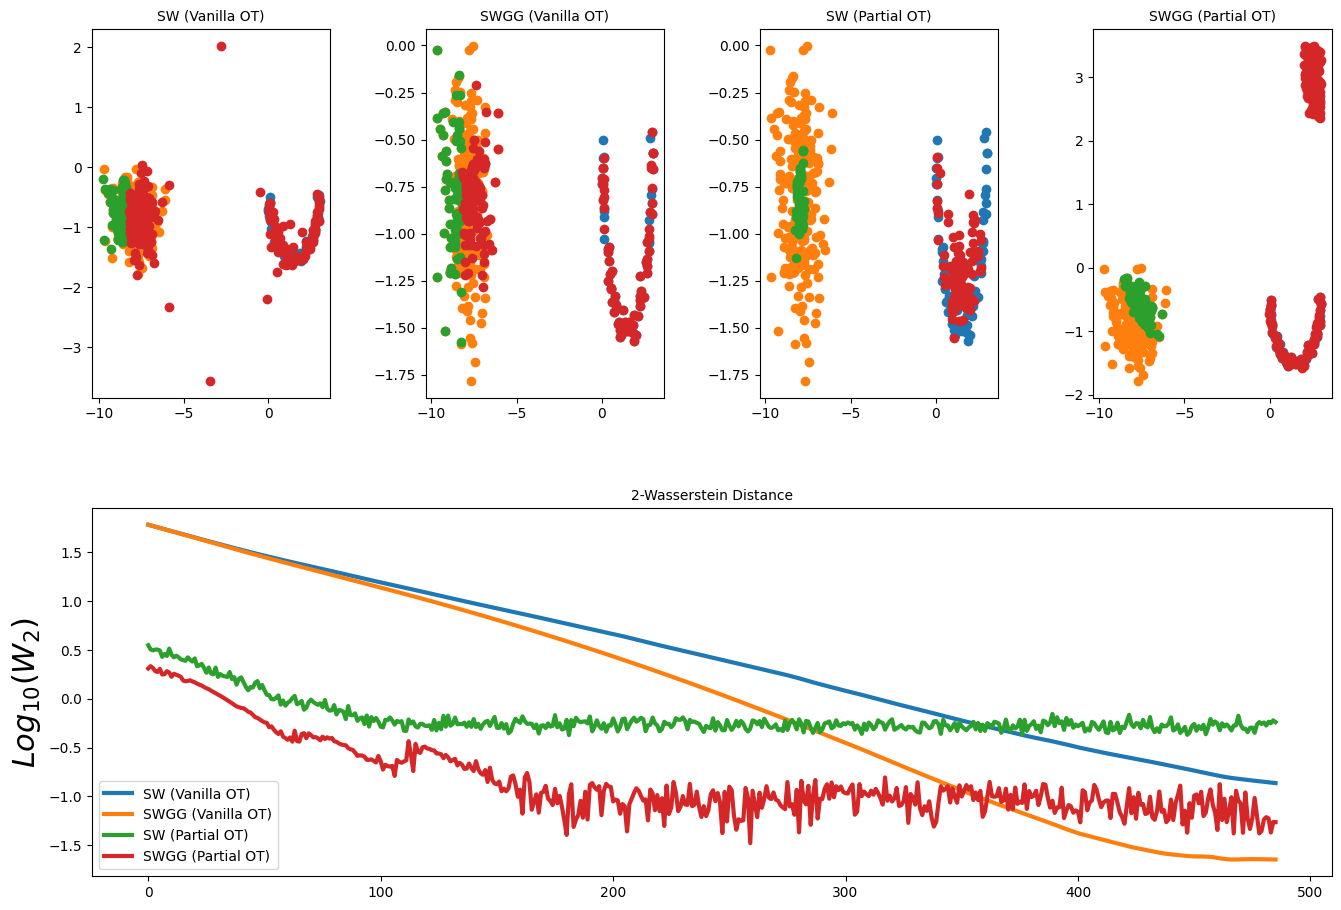

In [8]:
s = len(modes)
print("optimal number of samples", n_samples_mode2*2)

fig.clear()
fig = pl.figure(figsize=(4*s, 8+3))
grid = pl.GridSpec(2, s, wspace=.4, hspace=0.3)

plot_fig = True
mem_loss = []
e_swp = 0
e_swggp = 0

#nofiterations = 5
for i in range(nofiterations):
    print(i,end=' ')
    loss = list()
    theta = torch.ones(len(modes),d)
    
    for k in range(s):
        # Loss computation
        #loss_ = 0
        if k == 0:
            print(X.shape, Y[0].shape)
            l = gsw_res[k].sw(X.to(device), Y[k],theta=None)
        if k == 1:
            l, theta[k] = gsw_res[k].swgg(X.to(device), Y[k].to(device),theta=None)
        if k == 2:
            l, X_swp, Y_swp, e_swp = gsw_res[k].sw_partial_elbow(X.to(device), Y[k],theta=None)
        if k==3:
            l, theta[k], X_swggp, Y_swggp, e_swggp = gsw_res[k].swgg_partial_elbow(X.to(device), Y[k],theta=None)
        
        print(e_swp, e_swggp)
        # Optimization step
        loss_ = l
        loss.append(loss_)
        optimizer[k].zero_grad()
        loss[k].backward()
        optimizer[k].step()
        
        # Compute the 2-Wasserstein distance to compare the distributions
        if dist=='w2':
            w2_dist[i, k] = gradient_flows.w2(X.detach().cpu().numpy(), Y[k].detach().cpu().numpy())
            w2_dist_partial[i, k] = l#gradient_flows.w2(X.detach().cpu().numpy()[:n_samples_mode2*2], Y[k][ :n_samples_mode2*2].detach().cpu().numpy())
 
             
        theta2=theta.numpy()

        if plot_fig:
                temp = Y[k].detach().cpu().numpy()
                pl.subplot(grid[0, k])
                pl.cla()
                pl.scatter(X[:n_samples_mode1,0], X[:n_samples_mode1,1], c='C1')
                pl.scatter(X[n_samples_mode1: n_samples_mode2+n_samples_mode1,0], X[n_samples_mode1:n_samples_mode2+n_samples_mode1,1], c='C0')
                pl.scatter(temp[:n_samples_mode2,0], temp[:n_samples_mode2,1],c='C2')
                pl.scatter(temp[n_samples_mode2: n_samples_mode2+n_samples_mode1,0], temp[n_samples_mode2: n_samples_mode2+n_samples_mode1,1],c='C3')
                #pl.axline((0,0), theta2[k][0:2], color='C2')
                pl.title(titles[k], fontsize=10)
                xlim1,xlim2=pl.xlim()
                ylim1,ylim2=pl.ylim()
                pl.title(titles[k], fontsize=10)
    if plot_fig:
    # Plot the (partial) 2-Wasserstein distance
        pl.subplot(grid[1, 0:s])
        pl.cla()
        pl.plot(np.log10(w2_dist[:,:2]), linewidth=3)
        pl.plot(np.log10(w2_dist_partial[:,2:]), linewidth=3)
        pl.title('2-Wasserstein Distance', fontsize=10)
        pl.ylabel(r'$Log_{10}(W_2)$', fontsize=22)
        pl.legend(titles, fontsize=10, loc='lower left')
        
        
        display.clear_output(wait=True)
        display.display(pl.gcf()) 
        time.sleep(1e-5)    

        
    # Save the figure 
    
    fig.savefig(foldername + '/img%03d.png'%(i))
    for k in range(s):
        #pl.subplot(grid[:, k])
        pl.cla()
        
            
            